In [16]:
from scipy.stats import norm
from pandas import DataFrame
import numpy as np
import pandas as pd

def bsCall(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
def bsPut(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

vol = pd.read_csv('IV.csv', parse_dates=['Date']).iloc[1:, :].set_index('Date').dropna()
spx = pd.read_csv('data.csv', parse_dates=['Date'])[['Date', 'SPX']].set_index('Date')
param = pd.read_csv('LIBOR.csv', header=5, parse_dates=[0]).iloc[:, :2].set_index('Date').rename(columns={'PX_ASK': '1ML'}).merge(spx, on='Date')

dates = param.index.intersection(vol.index)
param = param.loc[dates]
param = param.assign(FWD=np.exp(param['1ML']/1200)*param['SPX'])
vol = vol.loc[dates]
strike = DataFrame(np.array([param['FWD'] + Delta for Delta in [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]]).T, 
                  columns=vol.columns, index=vol.index)

In [17]:
%%time

m, n = vol.shape
pv = np.empty_like(vol)
for i in range(m):
    for j in range(n):
        pricingFnc = bsCall if vol.columns[j][0] == 'C' else bsPut
        pv[i, j] = pricingFnc(  S=param['SPX'].iloc[i], 
                                K=strike.iloc[i, j], 
                                r=param['1ML'].iloc[i]/100, 
                                s=vol.iloc[i, j]/100, 
                                T=1/12)            
        
pv = DataFrame(pv, columns=vol.columns, index=vol.index)
pv.to_csv('pv.csv')

CPU times: user 20 s, sys: 31 ms, total: 20 s
Wall time: 20.1 s


In [21]:
from sklearn.preprocessing import normalize

pv = pd.read_csv('pv.csv', index_col=0)
pv.index = strike.index

DataFrame(normalize(pv/(strike**2)), index=pv.index, columns=pv.columns).to_csv('features.csv')

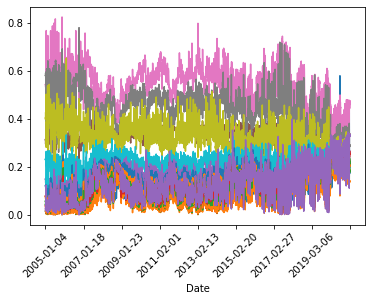

In [25]:
df = pd.read_csv('features.csv', index_col=0)

df.plot(rot=45, legend=None)
pass